In [1]:
%pip install datasets

  Using cached xxhash-3.5.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
Using cached multiprocess-0.70.16-py312-none-any.whl (146 kB)
Using cached xxhash-3.5.0-cp312-cp312-macosx_11_0_arm64.whl (30 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [datasets]2/3 [datasets]
Note: you may need to restart the kernel to use updated packages.


In [116]:
from datasets import load_dataset
import math
import torch
import torch.nn as nn
ds = load_dataset("mutiyama/alt", "alt-parallel")


In [28]:
ds['train'][0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'url': 'http://en.wikinews.org/wiki/2007_Rugby_World_Cup:_Italy_31_-_5_Portugal',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを

In this we can see that there are 4 features, denoting the id, url and translations. for our task of translation from burmese to english we only need the source, which is 'my' key in and the target which is 'en' key in translation. so we'll drop the rest of the columns

In [117]:


# train_dataset, test_dataset, val_dataset= clean_dataset(ds)
def clean_dataset(dataset):
    train_dataset = dataset['train']
    test_dataset = dataset['test']
    val_dataset = dataset['validation']
    
    # Create new dataset structure with id and translation dictionary
    def restructure(example, idx):
        return {
            'id': idx,
            'translation': {
                'burmese': example['translation']['my'],
                'english': example['translation']['en']
            }
        }
    
    # Apply restructuring with indices
    train_dataset = train_dataset.map(
        restructure, with_indices=True
    ).remove_columns(['SNT.URLID', 'SNT.URLID.SNTID', 'url'])
    
    test_dataset = test_dataset.map(
        restructure, with_indices=True
    ).remove_columns([ 'SNT.URLID', 'SNT.URLID.SNTID', 'url'])
    
    val_dataset = val_dataset.map(
        restructure, with_indices=True
    ).remove_columns(['SNT.URLID', 'SNT.URLID.SNTID', 'url'])
    
    # Filter out rows with None values
    train_dataset = train_dataset.filter(
        lambda x: x['translation']['burmese'] is not None and x['translation']['english'] is not None
    )
    
    test_dataset = test_dataset.filter(
        lambda x: x['translation']['burmese'] is not None and x['translation']['english'] is not None
    )
    
    val_dataset = val_dataset.filter(
        lambda x: x['translation']['burmese'] is not None and x['translation']['english'] is not None
    )
    
    return train_dataset, test_dataset, val_dataset

train_dataset, test_dataset, val_dataset = clean_dataset(ds)




In [86]:
print(train_dataset[0])
print(test_dataset[0])
print(val_dataset[0])

{'translation': {'burmese': 'ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂၀၀၇ခုနှစ် ရပ်ဘီ ကမ္ဘာ့ ဖလား တွင် အီတလီ သည် ပေါ်တူဂီ ကို ၃၁-၅ ဂိုး ဖြင့် ရေကူးကန် စီ တွင် ရှုံးနိမ့်သွားပါသည် ။', 'english': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.'}, 'id': 0}
{'translation': {'burmese': 'ဆစ်ဒနီ က ရန့်ဝစ်(ခ်) မြင်းပြိုင်ကွင်း မှ မျိုးသန့် ပြိုင်မြင်း ရှစ်ကောင် ဟာ မြင်းတုတ်ကွေးရောဂါ ကူးစက်ခံခဲ့ရတယ် ဆိုတာ အတည်ပြုခဲ့ပါတယ် ။', 'english': 'It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.'}, 'id': 0}
{'translation': {'burmese': '" သူ၏ ဆုံးပါးခြင်း အတွက် ကျွန်တော်တို့ ဝမ်းနည်း သော်ငြားလည်း ၊ လူမျိုးရေး နှင့် ဘာသာရေး ရန်စွယ် ကို နှိုးဆွပေး သော အမွေနှစ် တစ်ခု ကို သူ ချန်ထားခဲ့သည် ။ "', 'english': '"Though we are sad for his loss, he left a legacy that will inflame the enemy nation and religion."'}, 'id': 0}


{'burmese': 'အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု အဖြစ် စတုတ္ထ မိနစ် တွင် အမှတ်ပေးခြင်း ကို ဖွင့်လှစ်ပေးခဲ့သည် ။',
 'english': 'Andrea Masi opened the scoring in the fourth minute with a try for Italy.'}

tra

## TF Implementation

### embedding

In [233]:


class InputEmbeddings(nn.Module): #dmodel of 256 should be okay for this model
    def __init__(self, d_model: int, vocab_size: int):
        
        super().__init__()
        self.d_model=d_model
        self.vocab_size=vocab_size
        self.embedding=nn.Embedding(vocab_size,d_model)
    def forward(self,x):
        return self.embedding(x) * math.sqrt(self.d_model)
        


so we will be using character level tokenization for burmese to make things easier. we are going to choose the dmodel as 256 which means each character will be represented as a vector of size 256. if your sentence has 20 characters then you'll have 20 vectors each of size 256

As mentioned in the paper we are multiplying the embedding vectors by sqrt(dmodel) as mentioned in the paper. It helps maintain proper variance in the network, improves gradient flow during back propagation.This scaling factor might seem minor, but it's crucial for stable training. Networks without this scaling often train slower or fail to converge properly, especially as you increase the model depth.

In [205]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model: int, seq_len: int, dropout: float) -> None: 
        super().__init__()
        self.d_model=d_model
        self.seq_len=seq_len
        self.dropout=nn.Dropout(dropout)

        #create a matrix of shape(seq_len, d_model) each vector is of the size d_model
        pe=torch.zeros(seq_len,d_model)
        position=torch.arange(0,seq_len,dtype=torch.float).unsqueeze(1) # vector of shape (seq_len,1)
        div_term= torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0) / d_model)) #calculating in log space for numerical stability
        pe[:,0::2]=torch.sin(position * div_term)
        pe[:,1::2]=torch.cos(position * div_term)

        pe=pe.unsqueeze(0) #(1,seq_len,d_model) to add batch dimension
        self.register_buffer('pe',pe) #register buffer is used to register the pe matrix as a buffer, it is not a parameter of the model and is not updated during backpropagation

    
    def forward(self,x):
        x=x+self.pe[:,:x.shape[1],:].requires_grad_(False) #(batch_size,seq_len,d_model)
        return self.dropout(x)
    

        

sequence length is the maximum length a sentence can have, dropout is used to reduce overfitting. we are creating a matrix of size sequence length and dmodel for the positional encoding. the positional encoding is used to understand the word order in sentences which is crucial in understanding the context. so we add a unique position fingerprint to each token embedding. the positional encoding is not a learned parameter its only computed once and its stored in the model memory. we then apply a dropout to reduce overfitting.

In [222]:
class LayerNormalization(nn.Module):
    def __init__(self, features: int, eps: float = 10**-6) -> None:
        super().__init__()
        self.eps=eps #epsilon is used to avoid division by zero and to ensure numerical stability
        self.alpha=nn.Parameter(torch.ones(features)) #multiplicative factor
        self.bias=nn.Parameter(torch.zeros(features)) #additive factor


    def forward(self, x):
        mean=x.mean(dim=-1,keepdim=True) #mean of the last dimension
        std= x.std(dim=-1,keepdim=True)
        return self.alpha * (x-mean)/(std+self.eps) + self.bias #layer normalization formula from the paper



Layer normaliztion normalises each token's feature vector independently making mean =0 and variance =1 we use the formula given in the paper to do this. alpha and beta helps the model to tweak the mean and variance as required otherwise it would be forced to work with mean = 0 and variance =1 

In [45]:
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float)-> None:
        super().__init__()
        self.linear_1=nn.Linear(d_model,d_ff) #shape of the w1 matrix is d_ff,d_model pytorch creates a weight matrix of shape (out_features,in_features) and adds bias automatically
        self.dropout=nn.Dropout(dropout)
        self.linear_2=nn.Linear(d_ff,d_model)
    
    def forward(self,x):
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))


the ffn helps to introduce non linearity and increases the models learing capacity by expanding the dimension. attention determines which token to focus on while ffn determines what to do with the aggregate information. nn.linear applies a linear transformation y=xW^T + b. so in our case d_model is of 256 and d_ff is usually 4 times d_model so it becomes 1024. now it creates a matrix of shape 256,1024 and  our input is of the size [batch_sie, sequence_length, d_model]. so the output of linear1 will be of the shape [batch_size, sequence_length, d_ff] (eg: [1,256]*[256,1024] we take the transpose of w so the  output will be [1,1024]) now we apply dropout on it to randomly set elements to zero with probability p. then we apply linear 2 transformation which is of the shape [256,1024] eg([1,1024] multiplied by transpose of [256,1024], gives the output of size [1,256] )
so we get our original dimension back 

In [46]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float)-> None:
        super().__init__()
        self.d_model=d_model
        self.h=h
        self.d_k=d_model//h #we have to make sure that d_model is divisible by h. h is the number of heads.
        self.w_q=nn.Linear(d_model,d_model)
        self.w_k=nn.Linear(d_model,d_model)
        self.w_v=nn.Linear(d_model,d_model)
        self.w_o=nn.Linear(d_model,d_model)
        self.dropout=nn.Dropout(dropout)

    @staticmethod
    def attention(query,key,value,mask,dropout: nn.Module):
        d_k=query.shape[-1]


        attention_scores=(query @ key.transpose(-2,-1))/math.sqrt(d_k)  #(batch_size,h,seq_len,d_k) --> (bathc_size,h,seq_len,seq_len)

        if mask is not None:
            attention_scores.masked_fill_(mask==0,-1e9)
        attention_scores=attention_scores.softmax(dim=-1) #(batch_size,h,seq_len,seq_len)

        if dropout is not None:
            attention_scores=dropout(attention_scores)
        return (attention_scores @ value), attention_scores #attention_scores for visualization
    
    def forward(self,q,k,v,mask): #we use mask basically to avoid specific tokens interacting with each other. we do this before applying softmax
        query=self.w_q(q) #(batch_size,seq_len,d_model) --> (batch_size,seq_len,d_model)
        key = self.w_k(k) #(batch_size,seq_len,d_model) --> (batch_size,seq_len,d_model)
        value = self.w_v(v) #(batch_size,seq_len,d_model) --> (batch_size,seq_len,d_model)

        query=query.view(query.shape[0],query.shape[1],self.h,self.d_k).transpose(1,2) #(batch_size,seq_len,d_model) --> (batch_size,seq_len,h,d_k) --> (batch_size, h , seq_len, d_k)
        key=key.view(key.shape[0],key.shape[1],self.h,self.d_k).transpose(1,2)
        value=value.view(value.shape[0],value.shape[1],self.h,self.d_k).transpose(1,2)

        # (batch_size, h , seq_len, d_k) --> (batch_size, seq_len, h, d_k) --> (batch_size, seq_len, d_model)
        x, self.attention_scores=MultiHeadAttentionBlock.attention(query,key,value,mask,self.dropout)
        x=x.transpose(1,2).contiguous().view(x.shape[0],-1,self.h * self.d_k) #h*dk=d_model because d_k = d_model/h
        # (batch_size, seq_len, d_model) --> (batch_size, seq_len, d_model)
        return self.w_o(x)



first the input matrix of shape (seq,d_model) is split into 3 matrices of shape(seq,d_model) called query,key,value and we apply a linear transformation using the linear layer on each of them of shape(d_model,d_model) to get the output matrices Q', K' and V' of shape(seq,d_model), which was our input shape as well. We then choose the number of heads, the d_model should be divisible by number of heads. the value used in the paper was 8 but to keep the model use less resources we'll keep it to 4 in our implementation. now we use the view function to reshape te tensor without changing the data. we split the embedding dimension according to the number of heads which is a vector called dk of seq length which is defined by dmodel//h.we then transpose each of the q,k,v matrices in dimensions(1,2) i'e we swap number of heads and sequence length, so that each head gets access to the entire sequence allowing the heads to process the enire sequence length independently and in parallel we then calculate the attention scores by matrix multiplying query with the transpose of key(-2,-1) i.e we swap the last two dimensions. query_shape:[batch_size, h , seq_len, dk], key shape: [batch_size, h, seq_len, shape], key_transpose: [batch_size,h,d_k,seq_len] we divide it by square root of d_k the resulting matrix we get is of the shape [batch_size, h, seq_len, seq_len]. This shape represents attention scores between each pair of token, ie characters in our case. each cell[i,j] represents how much character i should attend to character j. acharacter might strongly attend to distant characters that complete its meaning. characters forming a single logical unit like a word will have strong mututal attention. the model kind of learns which character relationships matter without expliscit linguistic rules. the attention mechanism kind of automatically discovers meaningful relationships between characters even when they are separated by many positions and . Then we apply the mask function to  prevent certain connections between tokens. for ecample to mask padding token to prevent attenting to padding tokens it sets certain positions to -infinity before passing to the softmax so that their probability is effectively zero, so they get no attention then we pass it through a softmax and matrix multiply it with value matrix and return it.the attention scores represet how much each token should pay attention to every other token. For example, in the sentence "you are lovely" the token "lovey" might atted to token "you" and "are" because to understand who is lovely and how.higher scores means stronger relation ship. I think the magic of transformers lie in this mechanism. how its able to encode these data into an effective vector space and to succesfully embed the context into that vector space sounds very fascinating to me. I wonder how they came up with this.  then we concatinate each of the heads along embedding dimension it goes from [batch_size, seq_len,h*d_K] to batch_size,seq_len,dmodel] because dk=dmodel/h.so the linear transformation of w0 unifies diverese information from different heads and combine it into a unified embedding space as the input so that the model can carry on with its execution


tra

## Residual layer

In [211]:
class ResidualConnection(nn.Module):

    def __init__(self,features: int,dropout: float)-> None:
        super().__init__()
        self.dropout=nn.Dropout(dropout)
        self.norm=LayerNormalization(features)

    def forward(self,x,sublayer: nn.Module):
        return x+self.dropout(sublayer(self.norm(x)))

   
   
    
    

So residual layer is a type of connection that is used the input of a layer back to its output. 
output= x + layer(x), where layer is the transformation applied (either multi head attention or feed forward network). in deep neural networks gradients can either vanish or explode, which makes the training unstable. so they kind of solve that problem by making the output  a blend of the original input and the transformed version. even if multihead is poorly initialized it still has access to its original signal. the original paper uses a post-layer norm which basically means applying LayerNormalization after applyin the sublayer and adding the output back to the sublayer. But it has been found that prelayer norm leads to more stable training because inputs to the sublayer are normalized avoiding explosion/vanishing activations. so we are going to use pre norm here.

## Encoder Block

In [215]:
class EncoderBlock(nn.Module):

    def __init__(self,features: int,self_attention_block: MultiHeadAttentionBlock,feed_forward_block: FeedForwardBlock,dropout: float) -> None:
        super().__init__()
        self.self_attention_block=self_attention_block
        self.feed_forward_block=feed_forward_block
        self.residual_connections=nn.ModuleList([ResidualConnection(features,dropout) for _ in range(2)])

    def forward(self,x,src_mask):
        x=self.residual_connections[0](x,lambda x: self.self_attention_block(x,x,x,src_mask))
        x=self.residual_connections[1](x,lambda x: self.feed_forward_block(x))
        return x

we can have 'n' number of encoder blocks sequentially. each block processes the output of the previous block. each encoder block will have a multihead self attention sublayer, a feed forward sublayer and two residual connections one for each sublayers. the first residual connection normalises the input x, applies self attention with query, key and value all set to x. it then applies the dropout and adds the result back to original x. the second residual connection normalises the output from the previous step applies the feed forward network, applie dropout and adds the result back to the input of this sublayer.

In [210]:
class Encoder(nn.Module):
    def __init__(self, features: int, layers: nn.ModuleList)-> None:
        super().__init__()
        self.layers=layers #list of encoder blocks
        self.norm=LayerNormalization(features)
    
    def forward(self,x,mask):
        for layer in self.layers:
            x=layer(x,mask)
        return self.norm(x)

An Encoder contains multiple encoder blocks each containing a self attention mechanism, feed-forward network and residual connections stacked sequentially and then is finally passed through a layer normalization the original paper uses 6 encoder blocks stacked together in our case, i think 2-4 layers will be enough considering our hardware limits


## DecoderBlock

In [214]:
class DecoderBlock(nn.Module):
    def __init__(self,features: int,self_attention_block: MultiHeadAttentionBlock,cross_attention_block: MultiHeadAttentionBlock,feed_forward_block: FeedForwardBlock,dropout: float)-> None:
        super().__init__()
        self.self_attention_block=self_attention_block
        self.cross_attention_block=cross_attention_block
        self.feed_forward_block=feed_forward_block
        self.residual_connections=nn.ModuleList(ResidualConnection(features,dropout) for _ in range(3))

    def forward(self,x,encoder_output, src_mask, tgt_mask): #src mask and target mask because we are dealing with translation here and they have different sequences

        x=self.residual_connections[0](x,lambda x: self.self_attention_block(x,x,x,tgt_mask)) #mask of the decoder
        x=self.residual_connections[1](x,lambda x: self.cross_attention_block(x, encoder_output, encoder_output,src_mask)) #query from decoder, key and value from encoder hence the cross attention and the mask of the encoder
        x=self.residual_connections[2](x,lambda x: self.feed_forward_block(x))
        return x
    

in the decoder block we use the same positional embedding and the input embedding layers with just different parameters i guess. the vocab size, the sequence length would be different since we are dealing with two completely different languages. it has 3 residual connections, the first one adds the input to the output of self attention. the next residual connection combines the output of the previous self attention and applies cross attention to it with the current output as query encoder output as key and value. This is where the decoder kind of learns what parts of the source sentence to focus on when generating each target word. the third residual connection is to combine the output of the cross attention block with the feed forward blocks output. The decoder is made up of n decoder blocks. The source mask is used both in encoder and cross attention. it tells the model which tokens to ignore such as padding tokens. target mask is only used in the decoder self attention. this has two purposes one is to hide padding tokens and the other one is to prevent the decoder from seing the future tokens. during training we feed the entire target sequence into the decoder but the tokens can attend to only what it has seen so far so it essentially masks out the future tokens this kind of helps the decoder to learn the underlying function of input space and predict the next token based only on what it has seen so far

In [209]:
class Decoder(nn.Module):
    def __init__(self,features: int,layers: nn.ModuleList)-> None:
        super().__init__()
        self.layers=layers #list of decoder blocks
        self.norm=LayerNormalization(features)
    
    def forward(self,x,encoder_output,src_mask,tgt_mask):
        for layer in self.layers:
            x=layer(x,encoder_output,src_mask,tgt_mask)
        return self.norm(x)


we can have n number of decoder blocks arranged sequentially one after the other, each has a self attention sublayer, cross attention sublayer a feed forward sublayer, three residual connections(one for each sublayer) and normalization to the final output. th number of decoder = number of encoders (typically works well, but can be experimented with)

## Linear Layer

In [52]:
class ProjectionLayer(nn.Module): #this is the final layer of the decoder that projects the output of the decoder which is of shape (batch_size,seq_len,d_model) to (batch_size,seq_len,vocab_size) where vocab size is the size of the target vocabulary
    def __init__(self,d_model,vocab_size)-> None:
        super().__init__()
        self.proj=nn.Linear(d_model,vocab_size) #linear transformation to project the output of the decoder to the target vocabulary

    def forward(self,x):
        return torch.log_softmax(self.proj(x),dim=-1)

The projection layer helps us to convert the output of the transformer from batch_size, seq_len, d_model to batch_size, seq_len, vocab_size eseentially converting the output to an element in the target vocabulary. so we calculate the projection of the last dimension which is d_model and apply log_softmax for numerical stabilty which gives us the probability distribution of each token across the vocab size .

In [53]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embedding: InputEmbeddings, tgt_embedding: InputEmbeddings, src_pos_embedding: PositionalEncoding, tgt_pos_embedding: PositionalEncoding,projection_layer: ProjectionLayer)-> None:
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.src_embedding=src_embedding
        self.tgt_embedding=tgt_embedding
        self.src_pos_embedding=src_pos_embedding
        self.tgt_pos_embedding=tgt_pos_embedding
        self.projection_layer=projection_layer
        

    def encode(self, src, src_mask):
        src=self.src_embedding(src)
        src=self.src_pos_embedding(src)
        return self.encoder(src, src_mask)
    
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt=self.tgt_embedding(tgt)
        tgt=self.tgt_pos_embedding(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    
    def project(self,x):
        return self.projection_layer(x)

so this class defines the structure of a transformer and initializes a transformer object. we will have to specify its encoder, decoder, src_embeddings, target embeddings, position vectors of source and target embeddings, and the projection layer finally converts the transformer output to the vocabulary size. 

In [221]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=256, N: int=4, h: int =4, dropout: float=0.1, d_ff: int=1024)-> Transformer: #in the paper d_model=512, N=6, h=8,d_ff=2048
    
    src_embedding=InputEmbeddings(d_model, src_vocab_size)
    tgt_embedding=InputEmbeddings(d_model,tgt_vocab_size)
    src_pos_embedding=PositionalEncoding(d_model,src_seq_len,dropout)
    tgt_pos_embedding=PositionalEncoding(d_model,tgt_seq_len, dropout)

    encoder_blocks=[]
    for i in range(N):
        encoder_self_attention_block=MultiHeadAttentionBlock(d_model,h,dropout)
        feed_forward_block=FeedForwardBlock(d_model,d_ff,dropout)
        encoder_block=EncoderBlock(d_model,encoder_self_attention_block,feed_forward_block,dropout)
        encoder_blocks.append(encoder_block)

    decoder_blocks=[]
    for i in range(N):
        decoder_self_attention_block=MultiHeadAttentionBlock(d_model,h,dropout)
        decoder_cross_attention_block=MultiHeadAttentionBlock(d_model,h,dropout)
        feed_forward_block=FeedForwardBlock(d_model,d_ff,dropout)
        decoder_block=DecoderBlock(d_model,decoder_self_attention_block,decoder_cross_attention_block,feed_forward_block,dropout)
        decoder_blocks.append(decoder_block)
    
    encoder=Encoder(d_model,nn.ModuleList(encoder_blocks))
    decoder=Decoder(d_model,nn.ModuleList(decoder_blocks))

    projection_layer=ProjectionLayer(d_model,tgt_vocab_size)

    transformer=Transformer(encoder,decoder,src_embedding,tgt_embedding,src_pos_embedding,tgt_pos_embedding,projection_layer)

    for p in transformer.parameters():
        if p.dim()<2: continue
        nn.init.xavier_uniform_(p)
    
    return transformer

this function helps us to create a transformer with the given intial parameters.we first define the input and positional embeddings then create N encoder blocks which contains self attention, feed forward sublayers and residual connections. decoder blocks have cross attention as well as well as all the other elements an encoder block has. we then create the encoder blocks and decoder blocks by passing the appropriate parameters and then create a module list, then we define the projection layer finally we create a transformer object using these parts we created. we then use xavier uniform weight initialization. this is because without proper intialization networks struggle to learn effectively 

### Tokenizer

since burmese doesnt have clear word boundaries we are going to use character level tokenizer for burmese and word level tokenizer for english.

In [188]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace, CharDelimiterSplit, PreTokenizer, Split
from tokenizers.trainers import WordLevelTrainer
from pathlib import Path



def create_english_tokenizer(dataset,config):
    tokenizer_path=Path(config['tokenizer_file'].format('en'))
    if not Path.exists(tokenizer_path):
        tokenizer=Tokenizer(WordLevel(unk_token='[UNK]'))
        tokenizer.pre_tokenizer=Whitespace()
        trainer=WordLevelTrainer(special_tokens=['[PAD]','[SOS]','[EOS]','[UNK]'],min_frequency=2,vocab_size=10000)
        english_texts = (item['translation']['english'] for item in dataset)
        tokenizer.train_from_iterator(english_texts,trainer,length=len(dataset))
        tokenizer.save('tokenizer_en')
    else:
        tokenizer=Tokenizer.from_file(str(tokenizer_path))
    return tokenizer
 
def create_burmese_tokenizer(dataset,config):
    tokenizer_path=Path(config['tokenizer_file'].format('my'))
    if not Path.exists(tokenizer_path):
        tokenizer=Tokenizer(WordLevel(unk_token='[UNK]'))
        # tokenizer.pre_tokenizer=CharDelimiterSplit(delimiter='')
        # tokenizer.pre_tokenizer=Character()
        tokenizer.pre_tokenizer = Split(pattern="", behavior="isolated")
        trainer=WordLevelTrainer(special_tokens=['[PAD]','[SOS]','[EOS]','[UNK]'],min_frequency=2,vocab_size=2000)
        burmese_texts = (item['translation']['burmese'] for item in dataset)
        tokenizer.train_from_iterator(burmese_texts,trainer,length=len(dataset))
        tokenizer.save('tokenizer_my')
    else:
        tokenizer=Tokenizer.from_file(str(tokenizer_path))
    return tokenizer



tra

Create dataset

In [247]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class BilingualDataset(Dataset):
    def __init__(self, dataset, src_tokenizer, tgt_tokenizer, src_lang, tgt_lang, src_seq_len, tgt_seq_len)-> None:
        super().__init__()
        self.dataset=dataset
        self.src_tokenizer=src_tokenizer
        self.tgt_tokenizer=tgt_tokenizer
        self.src_lang=src_lang
        self.tgt_lang=tgt_lang
        self.src_seq_len=src_seq_len
        self.tgt_seq_len=tgt_seq_len

        self.sos_token=src_tokenizer.token_to_id('[SOS]')
        self.eos_token=src_tokenizer.token_to_id('[EOS]')
        self.pad_token=src_tokenizer.token_to_id('[PAD]')

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,idx):
        src_tgt_pair=self.dataset[idx]
        src_text=src_tgt_pair['translation']['burmese']
        tgt_text=src_tgt_pair['translation']['english']

        enc_input_tokens=self.src_tokenizer.encode(src_text).ids
        dec_input_tokens=self.tgt_tokenizer.encode(tgt_text).ids

  
        
        enc_num_padding_tokens=self.src_seq_len - len(enc_input_tokens) - 2 # subtracting 2 because of the sos and eos tokens
        dec_num_padding_tokens=self.tgt_seq_len - len(dec_input_tokens) - 1 # why -1 here?
        
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            # print(f"Warning: Sentence at index {idx} is too long. Source length: {len(enc_input_tokens)}, Target length: {len(dec_input_tokens)}")
            # Truncate if necessary
            enc_input_tokens = enc_input_tokens[:self.src_seq_len - 2]  # Leave room for SOS and EOS
            dec_input_tokens = dec_input_tokens[:self.tgt_seq_len - 1]  # Leave room for SOS
            
            
            

        # we combine the sos, enc_input_tokens, eos and padding tokens to form the encoder input
        encoder_input= torch.cat(
            [
                torch.tensor([self.sos_token],dtype=torch.int64),
                torch.tensor(enc_input_tokens,dtype=torch.int64),
                torch.tensor([self.eos_token],dtype=torch.int64),
                torch.tensor([self.pad_token]*enc_num_padding_tokens,dtype=torch.int64)

            ],dim=0
        )

        decoder_input = torch.cat(
            [
                torch.tensor([self.sos_token],dtype=torch.int64),
                torch.tensor(dec_input_tokens,dtype=torch.int64),
                torch.tensor([self.pad_token]*dec_num_padding_tokens,dtype=torch.int64)
            ],dim=0
        )

        label=torch.cat(
            [

            torch.tensor(dec_input_tokens, dtype=torch.int64),
            torch.tensor([self.eos_token],dtype=torch.int64),
            torch.tensor([self.pad_token]*dec_num_padding_tokens,dtype=torch.int64)
            ],dim=0
            
        )

        assert encoder_input.size(0)==self.src_seq_len
        assert decoder_input.size(0)==self.tgt_seq_len
        assert label.size(0)==self.tgt_seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'encoder_mask': (encoder_input!=self.pad_token).unsqueeze(0).unsqueeze(0).int(), #(1,1,seq_len) how? explain what does unsqueeze do
            'decoder_mask': (decoder_input!=self.pad_token).unsqueeze(0).unsqueeze(0).int() & causal_mask(decoder_input.size(0)),
            'label': label, #(seq_len)
            'src_text': src_text,
            'tgt_text': tgt_text
        }

def causal_mask(size):
    mask=torch.triu(torch.ones(1,size,size),diagonal=1).type(torch.int) # i get that we are setting the attention score of all the tokens after it to zeor right? but i dont really get the mask==0 part
    return mask ==0

so here we are ceating a Dataset class which we will use to train the model, it takes in the src language, trget language, its tokenizers and converts the sentence pairs in to their respective tokens. to be exact it takes in a sentence pair prepares the input for the encoder by concatenating the start of sentence token with the encoder input and adds the end of sentence token and finally adds the required amount of padding tokens to reach the fixed sequence length of the target. if my source and target sequence lengths are different where should i make those changes? then we create the decoder input which is a concatenation of start of sentence token, decoder input and the padding tokens. then we also create a label which is the actual output that the decoder is supposed to figure out. this labels are used in the loss function  then we also apply the binary and operatiion to apply the causal mask. so what the causal mask does is that, its the decoder's job to predict what comes next given the current, so it should not see the tokens infront of it. so the causal mask masks all the values in the attention output above the diagonal so each token only gets access to what it has seen. the triu function creates a matrix with 1s above the diagonal and we want to block those so we invert it with ==0. so essentially the & operation with the padding masks keeps only those positions that are not paddind and positions that are not future tokens.

## Train loop

### model config

In [255]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from pathlib import Path

def get_config():
    return {
        "batch_size": 4,
        "num_epochs": 20,
        "lr": 1e-4, #optimal learning rate as sugggested in the video
        "src_lang": "burmese",
        "tgt_lang": "english",
        "src_seq_len": 500, #95th percentile from training dataset, character tokenizer
        "tgt_seq_len": 55, #95th percentile from training dataset, word tokenizer
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel1",
        "ds_name": "mutiyama/alt",
        "ds_subset": "alt-parallel",
        "d_model": 256,
        "N": 6,
        "h": 4,
        "d_ff": 1024,
        "dropout": 0.1,
        "preload": None,
    }
def get_weights_file_path(config,epoch):
    model_folder=config['model_folder']
    model_basename=config['model_basename']
    model_filename = f"{model_basename}{epoch}.pt"
    return str(Path('.')/model_folder / model_filename)

In [256]:
def greedy_decode(model, source, source_mask,src_tokenizer,tgt_tokenizer,tgt_seq_len,device):
    sos_idx=src_tokenizer.token_to_id('[SOS]')
    eos_idx=src_tokenizer.token_to_id('[EOS]')
    # precompute the encoder output and reuse it for every token we get from the decoder
    encoder_output=model.encode(source,source_mask)

    #Initialize the decoder input with the sos token
    decoder_input=torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)
    while True:
        if decoder_input.size(1)==tgt_seq_len:
            break
        
        decoder_mask=causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)
        decoder_output=model.decode(encoder_output,source_mask,decoder_input,decoder_mask)
        prob=model.project(decoder_output[:,-1])
        _,next_word=torch.max(prob,dim=-1)
        decoder_input=torch.cat([decoder_input,torch.empty(1,1).type_as(source).fill_(next_word.item()).to(device)],dim=1)

        if next_word==eos_idx:
            break
    return decoder_input.squeeze(0)

  
def run_validation(model,validation_ds,src_tokenizer,tgt_tokenizer,tgt_seq_len,device,print_msg,global_state,writer,num_examples=5):
    model.eval()
    count=0
    source_texts=[]
    expected = []
    predicted = []
    console_width = 80 #size of the control window(defauly value)

    tgt_seq_len=config['tgt_seq_len']

    with torch.no_grad():
        for batch in validation_ds:
            count+=1
            encoder_input=batch['encoder_input'].to(device)
            encoder_mask=batch['encoder_mask'].to(device)


            assert encoder_input.size(0)==1, "Batch size must be 1 for validation"
            model_out=greedy_decode(model,encoder_input,encoder_mask,src_tokenizer,tgt_tokenizer,tgt_seq_len,device)

            source_text=batch['src_text'][0]
            target_text=batch['tgt_text'][0]
            model_out_text=tgt_tokenizer.decode(model_out.detach().cpu().numpy())
            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            print_msg('-'*console_width)
            print_msg(f"SOURCE: {source_text}")
            print_msg(f"TARGET: {target_text}")
            print_msg(f"PREDICTED: {model_out_text}")

            if count==num_examples:
                break
   

            


def get_ds(config):
    ds_name=config['ds_name']
    ds_subset=config['ds_subset']
    ds_raw=load_dataset(ds_name, ds_subset)
    train_ds, test_ds, val_ds= clean_dataset(ds_raw)

    src_tokenizer=create_burmese_tokenizer(train_ds,config)
    tgt_tokenizer=create_english_tokenizer(train_ds,config)

    train_ds1=BilingualDataset(train_ds,src_tokenizer,tgt_tokenizer,config['src_lang'],config['tgt_lang'],config['src_seq_len'],config['tgt_seq_len'])
    test_ds=BilingualDataset(test_ds,src_tokenizer,tgt_tokenizer,config['src_lang'],config['tgt_lang'],config['src_seq_len'],config['tgt_seq_len'])
    val_ds=BilingualDataset(val_ds,src_tokenizer,tgt_tokenizer,config['src_lang'],config['tgt_lang'],config['src_seq_len'],config['tgt_seq_len'])
    
    max_len_src=0
    max_len_tgt=0

    for item in train_ds['translation']:
       
        src_ids=src_tokenizer.encode(item['burmese']).ids
        tgt_ids=tgt_tokenizer.encode(item['english']).ids
        max_len_src=max(max_len_src,len(src_ids))
        max_len_tgt=max(max_len_tgt,len(tgt_ids))

    print(f'Maximum length of source sentence: {max_len_src}')
    print(f'Maximum length of target sentence: {max_len_tgt}')
   


    train_dataloader=DataLoader(train_ds1,batch_size=config['batch_size'],shuffle=True)
    test_dataloader=DataLoader(test_ds,batch_size=config['batch_size'],shuffle=True)
    val_dataloader=DataLoader(val_ds,batch_size=1,shuffle=True)

    return train_dataloader, test_dataloader, val_dataloader, src_tokenizer, tgt_tokenizer



def get_model(config,src_vocab_size,tgt_vocab_size):
    model=build_transformer(src_vocab_size, tgt_vocab_size, config['src_seq_len'], config['tgt_seq_len'], config['d_model'], config['N'], config['h'], config['dropout'], config['d_ff'])
    return model
    
def train_model(config):
    device=torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f"Using device: {device}")

    Path(config['model_folder']).mkdir(parents=True,exist_ok=True)

    train_dataloader, test_dataloader, val_dataloader, src_tokenizer, tgt_tokenizer=get_ds(config)
    model=get_model(config,src_tokenizer.get_vocab_size(),tgt_tokenizer.get_vocab_size()).to(device)
    writer=SummaryWriter(config['experiment_name'])

    optimizer=torch.optim.Adam(model.parameters(),lr=config['lr'],eps=1e-9)

    initial_epoch=0
    global_step=0

    if config['preload']:
        model_filename=get_weights_file_path(config,config['preload'])
        state=torch.load(model_filename)
        initial_epoch=state['epoch']+1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step=state['global_step']
    
    loss_fn=nn.CrossEntropyLoss(ignore_index=src_tokenizer.token_to_id('[PAD]'),label_smoothing=0.1).to(device)

    for epoch in range(initial_epoch,config['num_epochs']):
        
        batch_iterator=tqdm(train_dataloader,desc=f"Training epoch {epoch : 02d}")
        for batch in batch_iterator:
            model.train()
            encoder_input=batch['encoder_input'].to(device) #(batch_size,seq_len)
            decoder_input=batch['decoder_input'].to(device) #(batch_size,seq_len)
            encoder_mask=batch['encoder_mask'].to(device) #(batch_size,1,1,seq_len)
            decoder_mask=batch['decoder_mask'].to(device) #(batch_size,1,seq_len,seq_len)
 
        

            encoder_output=model.encode(encoder_input,encoder_mask) #(batch_size,seq_len,d_model)
            decoder_output=model.decode(encoder_output,encoder_mask,decoder_input,decoder_mask) #(batch_size,seq_len,d_model)
            proj_output=model.project(decoder_output) #(batch_size,seq_len,tgt_vocab_size)

            label=batch['label'].to(device) #(batch_size,seq_len)
            loss=loss_fn(proj_output.view(-1,tgt_tokenizer.get_vocab_size()),label.view(-1)) #whats happpening here?
            batch_iterator.set_postfix({"loss":f"{loss.item():6.3f}"})

            #log the loss to tensorboard
            writer.add_scalar('train_loss',loss.item(),global_step)
            writer.flush()

            loss.backward() #backpropagate the loss

            
            optimizer.step() #update the weights
            optimizer.zero_grad()

            global_step+=1

        run_validation(model,val_dataloader,src_tokenizer,tgt_tokenizer,config,device,lambda msg: batch_iterator.write(msg), global_step, writer)


        
        model_filename=get_weights_file_path(config,f"{epoch:02d}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step,
        },model_filename)



config=get_config()
train_model(config)







Using device: mps
Maximum length of source sentence: 826
Maximum length of target sentence: 123


Training epoch  0: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [29:29<00:00,  2.56it/s, loss=5.571]


--------------------------------------------------------------------------------
SOURCE: သောကြာ နေ့ တွင် ၊ အများဆုံး လူထု အသံလွင့် ဝန်ဆောင်မှု ဌာန နှင့်အတူ ၊ အေဘီစီ ၊ စီဘီအက်စ် ၊ အက်ဖ်အိုအိပ်စ် ၊ အန်န်ဘီစီ ၊ ဒဗလျူဘီ ၊ နှင့် ယူပီအန်န် စသော ၊ အဓိက အမေရိကန် ရုပ်မြင်သံကြား ကွန်ယက် ကြီး ခြောက် ခု လုံး သည် ပင်လယ်ကွေ့ ကမ်းရိုးတန်း အတွက် ပြပွဲ တစ် ခု ဖြစ်သော ၊ မုန်တိုင်း ရန် မှ ခိုလှုံရာ ဆိုသည့် တေးသီချင်း ကို လွင့် ရန် တစ် နာရီ စာ လှူဒါန်းပွဲ လေး တစ် ခု ကို ထူးခြားသော ပွဲ လေး တစ် ခု မှာ ၊ ပေါင်းစည်း ပြုလုပ်ခဲ့ကြသည် ။
TARGET: On Friday, all six major American television networks; ABC, CBS, FOX, NBC, WB, and UPN, along with most PBS stations, united in a rare show of solidarity to air a one hour charity concert called Shelter from the Storm: A Concert for the Gulf Coast.
PREDICTED: The , the , , , , , , , , , , , , , , , , , , , , ,
--------------------------------------------------------------------------------
SOURCE: ယခင် သြစတြေးလျ နိုင်ငံ ကိုယ်စားပြု အားကစား အသင်း အဖွဲ့ ဝင် များ အပါအဝင် အမျ

Training epoch  1: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [21:41<00:00,  3.47it/s, loss=6.094]


--------------------------------------------------------------------------------
SOURCE: ရဲ သတင်းဌာန မှ သတင်းပေးပို့ချက် အရ ၊ ရုရှား နိုက်ကလပ် တစ်ခု ၌ မနေ့က ပေါက်ကွဲမှု တစ်ရပ် သည် လူ အနည်းဆုံး ၉၄ ဦး သေဆုံးခဲ့ ပြီး နောက်ထပ် ၁၃၉ ဦး ဒဏ်ရာရရှိခဲ့သည် ။
TARGET: An explosion yesterday in a Russian nightclub killed at least 94 people and injured a further 139, according to police reports.
PREDICTED: The , the of the , was killed in the of the of the .
--------------------------------------------------------------------------------
SOURCE: ဝန်ကြီးချုပ် သည် ကျွန်းများ အား ဆန့်ကျင်တုံ့ပြန်မှု တစ်စုံတစ်ရာ မရှိစေ ရန် အုပ်ချုပ်ခဲ့ ပြီး ၊ ၎င်း သည် အနာဂတ် ငွေကြေး ဆိုင်ရာ ဘယ်လို ကူညီမှု မဆို ထိခိုက် လိမ့်မည် မဟုတ် ဟု ဆိုသည် ။
TARGET: The Prime Minister has ruled out any retaliation against the islands, saying it would not affect any future aid funding.
PREDICTED: The is a of the , and the , and the of the .
--------------------------------------------------------------------------------
SOURCE: အိန္ဒိယ

Training epoch  2: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [21:22<00:00,  3.53it/s, loss=5.954]


--------------------------------------------------------------------------------
SOURCE: သီချင်းစာအုပ်များ နှင့် ခက်ခဲစွာ စုဆောင်းထားသော မနုသဗေဒပညာများ ကို လက်ရှိ ဒစ်ဂျစ်တယ်ပြုလုပ်ထားသော အောက်စဖို့ဒ် တက္ကသိုလ် သည် ၊ အွန်လိုင်း မှ လှမ်းယူသုံးစွဲ ရန် ခွင့်ပြုထားသော စီမံချက် တစ်ခု ၏ အစိတ်အပိုင်း အဖြစ် စုဆောင်းထား ပြီး ၊ ကမ္ဘာ့ အကြီးဆုံး ဟု ပြောလို့ရသည် ။
TARGET: The University of Oxford is currently digitising the songbooks and anthologies of the Harding Collection, said to be the world's largest such collection, as part of a project to allow online access.
PREDICTED: The is a of the of the , , , , and .
--------------------------------------------------------------------------------
SOURCE: ချီကာဂို မှ အသက်၂၆နှစ်အရွယ်ရှိ ၊ အေပါဗီတှာ ဒူဂန် သည် ၊ ၅၉ လမ်းမကြီး တွင် တောင်ဘက်သို့ သွားနေရာ မှ ၈၈ အဝေးပြေးလမ်း သို့ လမ်းဖြတ်ခုံး တွင် ဘယ်ဘက် လှည့် ရန် ကြိုးစားခဲ့သည် ဟု နပါဗီလီ ရဲများ က သတင်းပို့ခဲ့ပါသည် ။
TARGET: Naperville police reported that Pavitra Durgam, a 26-year-old from Chicago, was trave

Training epoch  3: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [20:39<00:00,  3.65it/s, loss=5.504]


--------------------------------------------------------------------------------
SOURCE: လွန်ခဲ့တဲ့ အပတ် က ၊ ရက်ပါ ကန်နီ ဝက်စ် က အန်န်ဘီစီ လှူဒါန်း ပွဲ ဖြစ်သည့် ဟာရီကိန်း လေမုန်တိုင်း ချမ်းသာ ဘေးကင်းခွင့် အတွက် ဖျော်ဖြေပွဲ တစ် ခု အပေါ် ကို သဘောထား မှတ်ချက် တစ် ခု ချခဲ့သည် ၊ ထို မှတ်ချက် ထဲတွင် ဝက်စ် က “ ဂျော့ ဘုရှ် က လူ မည်း တွေ အကြောင်း ကို ဂရုမစိုက်ပါဘူး ။ ” ၊ ဟု အခိုင်အမာ ပြောဆိုခဲ့ ပြီး အငြင်းပွားမှု ကို ဖြစ်ပွားစေခဲ့သည် ။
TARGET: Last week, rapper Kayne West made a remark on an NBC charity show A Concert for Hurricane Relief, in which West claimed that "George Bush doesn't care about black people.", which caused controversy.
PREDICTED: In a statement , the of the , , , , , , .
--------------------------------------------------------------------------------
SOURCE: ပထမဦးဆုံး ပတ်လည် မဲ ပေး ပြီးနောက် လိမ္မော်ရောင် ဒီမိုကရက်တစ် လှုပ်ရှားမှု အဖွဲ့ အနေဖြင့် နောက်ထပ် မဲ လိုအပ်ချက် အရ ဦးဆောင်မှု တစ် ခု စေ့စပ်စွာ ဆောင်ရွက်လာခဲ့သည် ။
TARGET: After a first round of voting, the Orange Democra

Training epoch  4: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [20:18<00:00,  3.71it/s, loss=4.950]


--------------------------------------------------------------------------------
SOURCE: " ဒါဟာ စက်ပိုင်းဆိုင်ရာ ပြသနာ တစ်ခု နှင့် ချိတ်ဆက်နေလား ၊ ပင်ပန်းနွမ်းနယ်မှု သို့မဟုတ် လုံးဝ ကွဲပြားခြားနားသော အခြေအနေ ကြောင့်လား ? " ဟု ဘက်စ်ဆာရူး က အခင်းဖြစ်ပွားရာနေရာတွင် ပြောခဲ့သည် ။
TARGET: "Is this linked to a mechanical problem, drowsiness or a totally different cause?" Bussereau said at the scene.
PREDICTED: " We have been to the of the , and I ' m not going to be ," said .
--------------------------------------------------------------------------------
SOURCE: ထုတ်ပြန်ချက် တစ်ခု အတွက် ဝီကီသတင်းဋ္ဌာန သည် အေစီအမ်အေ ကို ဆက်သွယ်သည် ၊ သို့သော် ထို အစီရင်ခံစာ အရ ၊ အဲဒီမှာ တုန့်ပြန်ချက် လုံးဝမရှိပါ ။
TARGET: Wikinews contacted the ACMA for a statement, but as of this report, there was no response.
PREDICTED: The is the first of the , which is the , is the .
--------------------------------------------------------------------------------
SOURCE: ၁၇၀၈ ခုနှစ် ( မင်တန် ၏ သေဆုံးမှု ပြီးနောက် နှစ်ပေါင်

Training epoch  5: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [19:10<00:00,  3.93it/s, loss=5.428]


--------------------------------------------------------------------------------
SOURCE: အီးတီအေ က နွေရာသီ လများ အတွင်း စပိန် မြောက်ပိုင်း ရှိ ခရီးသွားဧည့် နေရာများ ကို ပုံမှန် ပစ်မှတ်ထားလေ့ ရှိသည် ။
TARGET: ETA has routinely targeted tourist destinations in northern Spain during summer months.
PREDICTED: The is expected to be to be in the .
--------------------------------------------------------------------------------
SOURCE: ဒီ ဖိနပ် တွေ ကို ၁၉၃၈ ခုနှစ် တွင် ရှာဖွေတွေ့ရှိခဲ့ ၊ ပြီး ယခု မတိုင်ခင် နှစ် ၁၀,၀၀၀ ခန့် အထိ ရက်စွဲတပ်ခဲ့သည် ။
TARGET: These shoes were discovered in 1938, and have been dated to about 10,000 years before present.
PREDICTED: The was in , , .
--------------------------------------------------------------------------------
SOURCE: အယ်ဂျာဇီရာ အစိုးရ သတင်း ဌာန အတွက် သတင်းပေးပို့သူ တစ်ဦး က " မီးရှုးမီးပန်းဗျောက်အိုးများ ကြောင့် ဖြစ်ပွားခဲ့ရသည့် အဆိုပါ မတော်တဆမှု သည် အရေးကြီးလှသော လူ့အသက် ကို ဆုံးရှုံးမှု တစ်ခု ဖြစ်စေသော ပေါက်ကွဲမှု တစ်ခု ဖြစ်ခဲ့တယ် ဆိုတာကို ပြောခြင်

Training epoch  6: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:49<00:00,  4.00it/s, loss=5.264]


--------------------------------------------------------------------------------
SOURCE: ရစ် ဖလဲ ( အမည် ရင်း ရစ်ချက် ဖလဲဟာ ) အဖမ်းခံရန် အတွက် ဝရမ်း ထုထ်ခံထားရသည် ။
TARGET: Ric Flair (real name Richard Fliehr) has a warrant out for his arrest.
PREDICTED: The ( ) is not the first time for the .
--------------------------------------------------------------------------------
SOURCE: ဘာကူမြို့ ဆင်ခြေဖုံး သို့ လမ်းခုလတ် တွင် လူ များစွာ တို့ ရဲတပ်ဖွဲ့ ၏ ဟန့်တားခြင်းခံခဲ့ရသည် ။
TARGET: Many people were stopped by police on their way to the outskirts of Baku.
PREDICTED: The police said that they were not the of the .
--------------------------------------------------------------------------------
SOURCE: ရီယို တင်တို သံ သတ္ထုရိုင်း မီးရထား တစ်စီး သည် ပီဘာရာ ၌ ၊ တွမ်ပရိုက်စ် မှ ဒမ်ပိုင်ယာလမ်း သို့ လမ်းခွဲ တစ်ခု ပေါ်တွင် ကြာသပတေးနေ့ ၂၉ က လမ်းချော်ခဲ့သည် ။
TARGET: A Rio Tinto iron ore train derailled at Pilbara, on a spur of the Tom Price to Dampier line on Thursday 29.
PREDICTED: The .
---------

Training epoch  7: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:45<00:00,  4.02it/s, loss=5.052]


--------------------------------------------------------------------------------
SOURCE: အီရတ် ၌ နှစ်ရက် တွင် ဗုံး လေးလုံး ကြဲခြင်း က ထိခိုက်ဒဏ်ရာ အမြောက်အများ နှင့်အတူ ၊ အနည်းဆုံး သေဆုံးသူ ၁၃၀ အထက် ရှိခဲ့သည် ။
TARGET: Four bombings in two days have left over 130 dead in Iraq, with at least as many injured.
PREDICTED: The , which was by the , was by the police in the .
--------------------------------------------------------------------------------
SOURCE: “ ကျွန်တော် သည် ကျွန်တော့် ဘ၀ ရဲ့ ဒီလို အခြေအနေမျိုး မှာ ကျွန်တော် ကိုကင်း မသုံးစွဲပါ ၊ ကျွန်တော့် ကိုယ်ကိုယ်ကိုယ် သတ်သေမကျူးလွန် ဖို့ ဆန္ဒ မရှိသမျှ ကာလပတ်လုံး ပေါ့နော် ” ။
TARGET: "I wouldn't take cocaine at this point in my life unless I wished to commit suicide."
PREDICTED: " We ' re going to get to the next day , but we ' re going to get to the of the people ," he said .
--------------------------------------------------------------------------------
SOURCE: ၂၀၀၆ ခုနှစ် ၊ ဒီဇင်ဘာ လ ၂၂ ရက် နေ့ တွင် အမေရိကန်ပြည်ထောင်စု ရှိ အိတ်စ်ဘေ

Training epoch  8: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:43<00:00,  4.02it/s, loss=4.714]


--------------------------------------------------------------------------------
SOURCE: ၎င်းကို အမေရိကန် ၊ ဘရာဗို နှင့် ဂျီဖိုး အစရှိသော များပြားလှသည့် ကေဘယ်လ် ကွန်ယက် များ နှင့် အင်တာနက် ပေါ် များ တွင် လည်း ပြသခဲ့ကြသည် ။
TARGET: It was also shown on the Internet and many cable networks such as USA, Bravo and G4.
PREDICTED: The , however , was by the and and .
--------------------------------------------------------------------------------
SOURCE: ထို့အပြင် အမတ်နေရာများ ဆုံးရှုံးမှုဖြစ်ခြင်း သည် အယ်လ်ဒီပီ ၏ ညွန့်ပေါင်း တွဲဘက် နယူး ကိုမီတို ( အင်န်ကေပီ ) ပါတီ လည်း ဖြစ်ခဲ့ပြီး ၎င်းပါတီ သည် အတိုင်ပင်ခံ အမတ်နေရာ ၄ နေရာ ဆုံးရှုံးခဲ့ရ ပြီး အခု နေရာ ၂၀ ကို ထိန်းသိမ်းထားသည် ။
TARGET: Also losing seats was LDP's coalition partner, New Komeito Party (NKP), which lost 4 councillor seats and now holds 20.
PREDICTED: The of the ( ) have been and has been by the ( ) and its .
--------------------------------------------------------------------------------
SOURCE: သင်္ဘော ၃၅၀၄ မှ အမှုထမ်း သင်္ဘော သာ

Training epoch  9: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:44<00:00,  4.02it/s, loss=4.364]


--------------------------------------------------------------------------------
SOURCE: စုံစမ်းစစ်ဆေးမှုများ သည် ဖလင်းဒါး လမ်းသွယ် နှင့် ဝီလီယမ် လမ်းဆုံ မှာ ဆောင်ရွက်ခဲ့ သောကြောင့် ၊ အရာရှိများ က ရုံး အလုပ်သမားများ အားလုံး ကို အဆောက်အအုံတွင်း နေရစ် ရန် သတိပေးခဲ့ ပြီး ၊ ဖလင်းဒါးစ် လမ်း ဘူတာရုံ က မီးရထား လေ့ကျင့်ပေးခြင်းများ သည် ယာယီ ရပ်တန့်ထားဆဲ ဖြစ်သည် ။
TARGET: Officials warned all office workers to remain indoors, and train services to Flinders Street Station were temporarily on hold, as investigations were carried out on the intersection of Flinders Lane and William Street.
PREDICTED: The investigation was also by the , and the , and the crew had been and by the and .
--------------------------------------------------------------------------------
SOURCE: နောက်ပိုင်း တွင် သူ သည် ဟာဗာနား သို့ ရွှေ့ပြောင်းခဲ့ ပြီး ထို နေရာ တွင် သူ သည် သူ ၏ ဆေးဘက်ဆိုင်ရာ လုပ်ငန်းများ ကို ဆက်လုပ်ခဲ့ပါသည် ။
TARGET: Later he moved to Havana where he continued his medical work.
PREDICTED: .
--------------

Training epoch  10: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:48<00:00,  4.01it/s, loss=4.035]


--------------------------------------------------------------------------------
SOURCE: ခရစ်ယာန်ဂိုဏ်းအုပ်များအဖွဲ့အစည်းက ပြုလုပ်သော ကြေငြာချက် အရ အင်္ဂလန်၏ အသင်းတော်သည် တရားဝင်လက်တွဲဖော်ရှိသူ လက်မထပ်ရသေးသော လိင်တူချစ်သူအမျိုးသားများကို ဂိုဏ်းအုပ်ဆရာတော်များ ဖြစ်ခွင့်ပေးရန် စီစဉ်နေသည် ။
TARGET: The Church of England are planning to allow gay men who are celibate and in a civil partnership to become bishops according to an announcement made by the House of Bishops.
PREDICTED: The UN ' s is a that the .
--------------------------------------------------------------------------------
SOURCE: ကနေဒီယန် သမိုင်း တွင် အကြွေးငွေ ပေးချေမှု ကြေညာမှု့ သည် အကြီးဆုံး ဖြစ်ခဲ့သည် ။
TARGET: The announced debt payment is the largest in Canadian history.
PREDICTED: The of the was the first time for the country .
--------------------------------------------------------------------------------
SOURCE: ကလင်တန် ၏ အစီအစဥ် ကြောင့် ဆန္ဒပြပွဲ သည် တစ် ပတ် နှောင့်နှေးခဲ့ရသည် ။
TARGET: The rally was delayed one we

Training epoch  11: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:40<00:00,  4.04it/s, loss=4.327]


--------------------------------------------------------------------------------
SOURCE: လျှပ်စစ် လိုင်း များ ၊ ကြော်ငြာ ဆိုင်းဘုတ် များ ၊ နှင့် ရုံး ကုလားထိုင် များ တောင် ပါဝင် သော ၊ အပျက်အစီး များ ကြောင့် ရဲ တပ်ဖွဲ့ က စီအန်အန် ဌာန အနီး က လမ်း အများအပြား ကို ပိတ် ခဲ့ သည် ။
TARGET: Police closed several streets near the CNN Center because of the debris, which included power lines, billboards, and even office chairs.
PREDICTED: , , and , were by the and .
--------------------------------------------------------------------------------
SOURCE: ဩစတြေးလျရဲ့ ’ ဆင်ဆာလုပ်ငန်း လွှတ်တော်အမတ် ’ စတီဗန်ကွန်လွေး မှာ သူ၏ နည်းလမ်း ရှိတယ် ဆိုရင် ၊ ဩစတြေး သည် မဖြစ်မနေ အင်တာနက် ဆင်ဆာလုပ်ငန်း အုပ်ချုပ်မှုစနစ် တစ်ခု ရှိသည့် ပထမဆုံး အနောက်နိုင်ငံ ဖြစ်လာလိမ့်မည် ဟု ဝီကီလိခ် က သူတို့ရဲ့ ဝက်ဘ်ဆိုက် ပေါ်တွင် နောက်ထပ် ကြေငြာချက် မှာ ပြောခဲ့ပါ တယ် ။
TARGET: "If Australia's 'Senator for Censorship', Steven Conroy, has his way, Australia will be the first Western country to have a mandatory Internet censorship reg

Training epoch  12: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:45<00:00,  4.02it/s, loss=4.121]


--------------------------------------------------------------------------------
SOURCE: သမုဒ္ဒရာ-မျက်နှာပြင် အပူချိန် သည် လွန်ခဲ့သော ၁၂၈ နှစ် ကာလ အတွင်း ဒုတိယ အပူနွေးဆုံး ဖြစ်ခဲ့သည့် အချိန်တွင် ၊ တစ်ကမ္ဘာလုံးဆိုင်ရာ မြေ-မျက်နှာပြင် အပူချိန် သည် ပြင်းထန်သော အီးအယ်လ် နီနို ၁၉၉၇-၁၉၉၈ အပိုင်း အတောအတွင်း ရှိခဲ့သော မှတ်တမ်း ထက် ၀.၀၆ ဒီဂရီ စင်တီဂရိတ် ခန့် ထက် ပို၍ အေးခဲနေ ပြီး ၊ မှတ်တမ်း တွင် အပူနွေးဆုံး ဖြစ်ခဲ့သည် ။
TARGET: The global land-surface temperature was the warmest on record, while the ocean-surface temperature tied for second warmest in the past 128 year period, approximately 0.06 degrees C cooler than the record established during the strong El Niño episode of 1997-1998.
PREDICTED: The company was founded in - and was in - , which was - , in 1999 , the - - and - - in the - .
--------------------------------------------------------------------------------
SOURCE: လက်ရှိ စွဲချက်တင်ခြင်း က ၎င်း စွပ်စွဲချက်များ အပေါ် မှ မည်သည့် စွဲချက်များ မှ ပါဝင်ခြင်း မရှိပါ ။
TARGET: The present 

Training epoch  13: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:47<00:00,  4.01it/s, loss=4.536]


--------------------------------------------------------------------------------
SOURCE: အန်အင်အက်ဆောရဲလာ ၏ မိန့်ခွန်း သည် သူပုန် အုပ်စု သည် ဆီးရီးယား ၏ စစ်ပွဲ တွင် တိုက်ရိုက် ပါဝင်ခဲ့ကြကြောင်း အတည်ပြုခဲ့ ပြီး ၊ သူ တို့ သည် လက်ဗနွန် ၏ နယ်စပ် ကို သူပုန်များ ၏ ထိန်းချုပ်မှု မှ ကာကွယ်သွားမည် ဟု ကတိပြုခဲ့သည် ။
TARGET: Nasrallah's speech confirmed the group are directly involved in Syria's war, and pledged they would protect Lebanon's borders from the control of rebels.
PREDICTED: The ' s defense minister , , said that the judge would not be allowed to his own and that his work .
--------------------------------------------------------------------------------
SOURCE: ဝေဖန်သူများ က ကွန်ဆာဗေးတစ် အစိုးရ သည် သူတို့ သည် စတင် ရုံးထိုင် သောအခါ တွင် ကနေဒါ နိုင်ငံသားများ က အခွန်အခ လွန်စွာ ကောက်ခံခြင်းခံခဲ့ရသည် ကို ပြောကြားခဲ့သည် ဟု ထောက်ပြခဲ့ ပြီး ၊ " အံ့ဩဖွယ် အပိုအလျှံ " ပပျောက် ရန် ခိုင်ခိုင်မာမာကတိပေးခဲ့သည် ။
TARGET: Critics point out that the Conservative government had said Canadians were overt

Training epoch  14: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:39<00:00,  4.04it/s, loss=4.225]


--------------------------------------------------------------------------------
SOURCE: ယူကေ လေ့လာမှု ၏ အလုပ်လုပ်ပေးနေသော သီအိုရီ များ ကဲ့သို့ ၊ ကလေး များ ကို ထိတွေ့ ကူးစက်ခြင်း သည် ကလေးများအဖြစ်များသော ကင်ဆာ ရောဂါ များ ဖွံ့ဖြိုးမှု -- တစ်ခု နှင့် ဆက်နွယ်နေ သော သီအိုရီ များ သည် ၁၉၄၀ နီးပါး ကတည်းက ရှိခဲ့ ၊ ပြီး မစွဲကပ်စေသော စိန်ခေါ်မှု များ ကင်းမဲ့ခြင်း က ရောဂါကူးစက်ခြင်း ၏ အချို့သော အမျိုးအစား များ ၏ ရလဒ် တစ်ခု သည် နှောင့်နှေး သောကြောင့် လူကီးမီးယား ဖြစ်ထွန်းလာ သော ၊ အခြား အချက် တစ်ခု ဖြစ်လာသည် လို့ ပြောကြားခဲ့သည် ။
TARGET: Theories have been around since the 1940s that childhood exposure to infection was related to the development of childhood leukaemia — one, like the working theory of the UK study, said that lack of immune challenge was a factor, another that leukaemia developed as a delayed result of some type of infection.
PREDICTED: The Australian Capital Territory Territory has announced their plans to the of the of the , who had been a of since the Australian Capital Territory

Training epoch  15: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:47<00:00,  4.01it/s, loss=3.526]


--------------------------------------------------------------------------------
SOURCE: စပင်ဆာ ဒရိုင်ဒန် သည် အဆိုပါ အဖွဲ့ ၏ အအောင်မြင်ဆုံးအချိန် မှာ ဂျက်ဖာဆန် အဲပလိန်း ၏ အဖွဲ့ဝင် တစ်ယောက် ဖြစ်ခဲ့သည် ။
TARGET: Spencer Dryden was a member of Jefferson Airplane during the band's heyday.
PREDICTED: The first leg of the match was the first half of the first half of the match .
--------------------------------------------------------------------------------
SOURCE: အယ်အက်စ်ဘီ ၃.၁ သည် လင်းနစ် ၏ အဓိကကျသော အပိုင်းများ ကို ပိုမိုလွယ်ကူသော တီထွင်မှု ပြုလုပ် ရန် စံသတ်မှတ်ထားသည် ။
TARGET: LSB 3.1 standardizes core pieces of Linux to make development easier.
PREDICTED: The of the is the largest in the world for the weekend .
--------------------------------------------------------------------------------
SOURCE: ပြောရေးဆိုခွင့်ရှိသူ က ဆွေးနွေးမှု တစ် ခု ကို ဘယ်လို စတင်သင့် ကြောင်း ဆုံးဖြတ်တဲ့ အချိန် မှာ ဥပဒေရေးဆွဲသူ ရိုင်လာအိုဒင်နာဂါ ၏ ဆန့်ကျင်ဘက် လိမ္မော်ရောင် ဒီမိုကရက်တစ် လှုပ်ရှားမှု အဖွဲ့ ကို မ

Training epoch  16: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [20:52<00:00,  3.61it/s, loss=3.785]


--------------------------------------------------------------------------------
SOURCE: ကုလသမဂ္ဂ က လူ တစ် သန်း ဟာ အိုးမဲ့အိမ်မဲ့ ဖြစ်ကြတယ် ၊ ဒါမှမဟုတ် အခြား အချို့ နည်းလမ်း တွင် အကူအညီ လိုအပ်နေတယ် လို့ အစီရင်ခံခဲ့သည် ။
TARGET: The United Nations has reported that one million people are homeless, or in need of help in some other way.
PREDICTED: The UN has confirmed that they had been aware of the , but that it is unlikely that the situation was .
--------------------------------------------------------------------------------
SOURCE: အဆိုပါ ဖိနပ် နှင့် ဥမင် သည် သုတေသနပြု ဖို့ ရန် ဆက်လက်ရှိပါလိမ့်မယ် ။
TARGET: The shoe and the cave will continue to be researched.
PREDICTED: The storm will be expected to be operating in the region .
--------------------------------------------------------------------------------
SOURCE: သူ သည် စစ်ပွဲ-ဆန့်ကျင်သော ရုပ်ရှင်ကား မှ အမှန်တကယ် မြင်ကွင်း တစ်ခု ဖြစ် သော ၊ မုဒိမ်းကျင့်သည့် ရုပ်ရှင် အတု များ ကဲ့သို့ ပစ္စည်း များ ကို လက်ခံခြင်း မှတဆင့် တစ်ဦးတည်း အစွ

Training epoch  17: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [26:04<00:00,  2.89it/s, loss=3.633]


--------------------------------------------------------------------------------
SOURCE: သို့သော် ၎င်း သည် ၎င်းတို့ ၏ အကျိုးအမြတ် ကို တိုးတက် ရန် ကြိုးပမ်းမှု တစ်ခု ကို ၎င်း ကဲ့သို့ ပြုလုပ်ခဲ့ သည့် နိုကီရာ ကုမ္ပဏီ က ပထမဆုံး အကြိမ် မဟုတ်ပါဘူး ။
TARGET: But this is not the first time Nokia has made an attempt like this to increase its revenue.
PREDICTED: But it would not be used to reduce its own content in its own or form of companies they will not be .
--------------------------------------------------------------------------------
SOURCE: ဒေသ ဆိုင်ရာ ရဲတပ်ဖွဲ့ အကြီးအကဲ ဟားဘတ် ကဲမ်ဘာ က : “ ရက်စက်သော လူသတ်မှု ၏ အဓိက စီစဉ်သူ လို့ ယုံကြည်ခဲ့သည့် သံသယရှိသူ ကို ကင်ညာ နယ်စပ် မြို့ တာဗက်တာ ၌ ပုန်းရှောင်နေသည် ကို ရဲတပ်ဖွဲ့ က ဖမ်းဆီးခဲ့ကြောင်း ယခုနေ့ တွင် ကြေငြာခဲ့သည် ။
TARGET: Regional police chief Herbert Khaemba anounced today: "The suspect believed to be the main organiser of the brutal murder was arrested by the police at the Kenyan border town of Taveta in hiding.
PREDICTED: The driver of

Training epoch  18: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:21<00:00,  4.10it/s, loss=3.902]


--------------------------------------------------------------------------------
SOURCE: သူ၏ သေဆုံးမှု နှင့်ပတ်သတ်၍ သူတို့ မသိခဲ့ဘူးလို့ ပါကစ္စတန် အစိုးရ က ပြောခဲ့သည် ။
TARGET: The Government of Pakistan said they did not know about his death.
PREDICTED: His and were not allowed to stop them .
--------------------------------------------------------------------------------
SOURCE: ရာဘင် နှင့် စပ်လျဉ်း၍ ၊ ကလင်တန် က “ ကျွန်တော် သူ့ ကို အလွန် နှစ်သက်ပါတယ် ၊ ပြီးတော့ နိုင်ငံရေးသမား တစ်ဦး အား တိုင်းပြည် အုပ်ချုပ်တတ်သူ တစ်ဦး ၊ စစ်သား တစ်ယောက် ဖြစ်နေခြင်း မှ ငြိမ်းချမ်းရေး ဖော်ဆောင်သူ တစ်ယောက် အဖြစ် သို့ ၊ ပြောင်းလဲနိုင် ရန် သူ့ ရဲ့ စွမ်းရည် ကို ကျွန်တော် အံ့ဩခဲ့ရပါတယ် ” ဟု ၊ ပြောကြားခဲ့သည် ။
TARGET: Regarding Rabin, Clinton said, "I loved him very much, and I was in awe of his ability to move from being a soldier to being a peacemaker, a politician to a statesman".
PREDICTED: , a of the , said : " We have a very of hope and the of the best people , they have to do that , but not the fact t

Training epoch  19: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:51<00:00,  4.00it/s, loss=3.335]


--------------------------------------------------------------------------------
SOURCE: အမျိုးသမီး များ ပွဲစဉ် တွင် ၊ ဂျင်နီ ဖေး သည် မီချဲလ် အိန်းစ်ဝသ် ကို ဦးဆောင် ၍ ၄ နာရီ ၁ မိနစ် ၅၃ စက္ကန့် အချိန် တွင် အနိုင်ရခဲ့သည် ။
TARGET: In the women's event, Jenny Fay won in a time of 4:01:53 ahead of Michelle Ainsworth.
PREDICTED: The women , who were aged 47 , were aged 47 and a woman who was aged 47 .
--------------------------------------------------------------------------------
SOURCE: သူ သည် လူသတ်မှု ၊ ပြန်ပေးဆွဲမှု ၊ အကြမ်းဖက် အုပ်စုများ ကို ကူညီပေးမှု နှင့် အမေရိကန် ပြည်ထောင်စု အပြင် ဘက် ရှိ အမေရိကန် ပြည်ထောင်စု နိုင်ငံတော်များ ကို ဆန့်ကျင်သော အခြား လုပ်ဆောင်ချက်များ ကျူးလွန် ရန် ပူးပေါင်းကြံစည်မှု ဖြင့် စွဲချက်တင်ခံခဲ့ရသည် ။
TARGET: He is charged with conspiracy to commit murder, kidnapping, aiding terrorist groups and other acts against US nationals outside the United States.
PREDICTED: He has been criticized for the United States Senate in Iraq for several years , including US citi

Files in current directory: ['.config', 'Music', 'logistic_net_graph', 'webots-R2023b.dmg', '.cursor', '.zprofile.pysave', '.codegpt', '.condarc', '.docker', 'component_loadings.png', 'Untitled1.ipynb', '.DS_Store', 'correlation_matrix.png', '.CFUserTextEncoding', 'test', '.llama', 'variable_variances.png', '.xonshrc', 'anaconda_projects', 'Untitled.ipynb', '.zshrc', 'weights', '.streamlit', '.local', '.psql_history', 'Pictures', 'raw_data2.png', '.zprofile', 'kmeans_clusters.png', 'Postman', '.zsh_history', 'Untitled2.ipynb', '.ipython', 'pairplot.png', 'Desktop', 'Library', '.matplotlib', '.lesshst', 'component_projections.png', '.pgadmin', 'tokenizer_my', 'Public', '.idlerc', 'Untitled.R', '.tcshrc', '.anaconda', '.ssh', 'Movies', 'Applications', 'variable_distributions.png', '.Rapp.history', '.Trash', 'KMNIST', '.ipynb_checkpoints', '.jupyter', '.npm', 'Documents', '.anydesk', '.bash_profile', 'Downloads', '.python_history', '.continuum', '.cache', 'runs', '.ollama', '.bash_history

In [260]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/jithuazeez


In [262]:
import os
model_folder = config['model_folder']
if os.path.exists(model_folder):
    print(f"Directory '{model_folder}' exists")
    print("Files in model directory:", os.listdir(model_folder))
else:
    print(f"Directory '{model_folder}' does not exist")

Directory 'weights' exists
Files in model directory: ['tmodel_15.pt', 'tmodel_05.pt', 'tmodel_11.pt', 'tmodel_01.pt', 'tmodel_10.pt', 'tmodel_00.pt', 'tmodel_14.pt', 'tmodel_04.pt', 'tmodel_19.pt', 'tmodel_09.pt', 'tmodel_18.pt', 'tmodel_08.pt', 'tmodel_13.pt', 'tmodel_03.pt', 'tmodel_17.pt', 'tmodel_07.pt', 'tmodel_16.pt', 'tmodel_06.pt', 'tmodel_12.pt', 'tmodel_02.pt']


Burmese character length statistics:
50th percentile: 177.0
75th percentile: 235.0
90th percentile: 303.0
95th percentile: 348.0
98th percentile: 410.0
99th percentile: 460.0

English word length statistics:
50th percentile: 21.0
75th percentile: 28.0
90th percentile: 36.0
95th percentile: 41.0
98th percentile: 48.0
99th percentile: 53.0


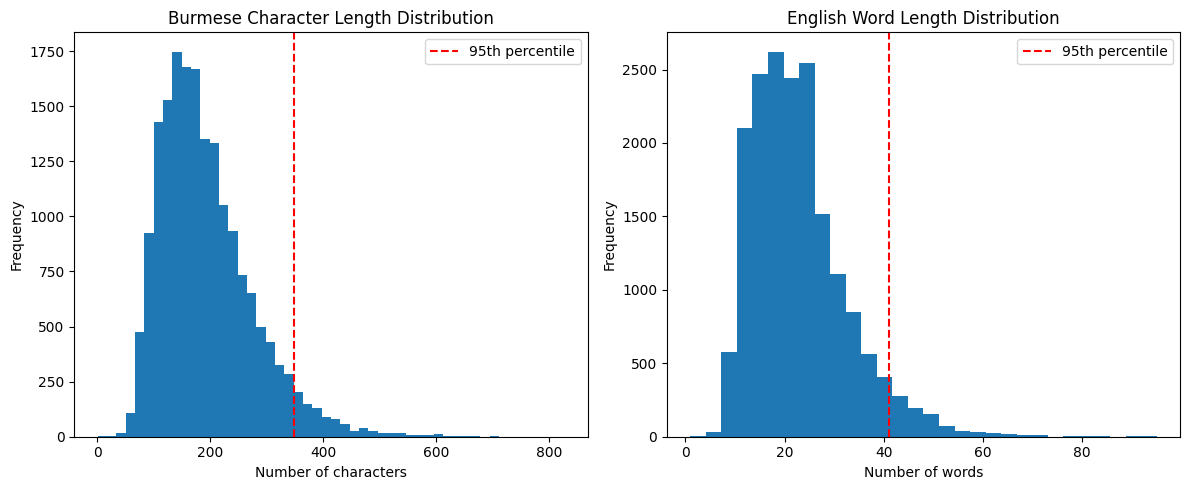

In [259]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

burmese_lengths = [len(list(item['translation']['burmese'])) for item in train_dataset]
# For English word lengths
english_lengths = [len(item['translation']['english'].split()) for item in train_dataset]

# Calculate percentiles
percentiles = [50, 75, 90, 95, 98, 99]
burmese_stats = {p: np.percentile(burmese_lengths, p) for p in percentiles}
english_stats = {p: np.percentile(english_lengths, p) for p in percentiles}

print("Burmese character length statistics:")
for p, v in burmese_stats.items():
    print(f"{p}th percentile: {v:.1f}")

print("\nEnglish word length statistics:")
for p, v in english_stats.items():
    print(f"{p}th percentile: {v:.1f}")

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(burmese_lengths, bins=50)
plt.title('Burmese Character Length Distribution')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.axvline(burmese_stats[95], color='r', linestyle='--', label='95th percentile')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(english_lengths, bins=30)
plt.title('English Word Length Distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.axvline(english_stats[95], color='r', linestyle='--', label='95th percentile')
plt.legend()

plt.tight_layout()
plt.show()

tra

tra

In [242]:
# Create tokenizers
src_tokenizer = create_burmese_tokenizer(train_dataset, config)
tgt_tokenizer = create_english_tokenizer(train_dataset, config)

# Function to inspect tokenization
def inspect_tokenization(text, tokenizer, is_character_level=True):
    encoded = tokenizer.encode(text)
    tokens = encoded.tokens
    ids = encoded.ids
    
    print(f"Original text: {text}")
    print(f"Tokenized into {len(tokens)} tokens:")
    
    # Print each token and its ID
    for i, (token, id) in enumerate(zip(tokens, ids)):
        print(f"  {i+1}. '{token}' → ID: {id}")
    
    # For character tokenization, verify each character
    if is_character_level:
        print("\nCharacter by character verification:")
        for i, char in enumerate(text):
            if i < len(tokens):
                print(f"  Character '{char}' → Token '{tokens[i]}'")
            else:
                print(f"  Character '{char}' → Not tokenized!")

# Inspect a few examples
burmese_samples = [train_dataset['translation'][i]['burmese'] for i in range(3)]
english_samples = [train_dataset['translation'][i]['english'] for i in range(3)]

for i, (bur, eng) in enumerate(zip(burmese_samples, english_samples)):
    print(f"\n=== Sample {i+1} ===")
    print("BURMESE TOKENIZATION (Character-level):")
    inspect_tokenization(bur, src_tokenizer, is_character_level=True)
    print("\nENGLISH TOKENIZATION (Word-level):")
    inspect_tokenization(eng, tgt_tokenizer, is_character_level=False)
    print("\n" + "="*50)


=== Sample 1 ===
BURMESE TOKENIZATION (Character-level):
Original text: ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂၀၀၇ခုနှစ် ရပ်ဘီ ကမ္ဘာ့ ဖလား တွင် အီတလီ သည် ပေါ်တူဂီ ကို ၃၁-၅ ဂိုး ဖြင့် ရေကူးကန် စီ တွင် ရှုံးနိမ့်သွားပါသည် ။
Tokenized into 156 tokens:
  1. 'ပ' → ID: 17
  2. 'ြ' → ID: 20
  3. 'င' → ID: 12
  4. '်' → ID: 5
  5. 'သ' → ID: 15
  6. 'စ' → ID: 22
  7. '်' → ID: 5
  8. 'န' → ID: 16
  9. 'ိ' → ID: 11
  10. 'ု' → ID: 8
  11. 'င' → ID: 12
  12. '်' → ID: 5
  13. 'င' → ID: 12
  14. 'ံ' → ID: 33
  15. ' ' → ID: 4
  16. 'ပ' → ID: 17
  17. 'ါ' → ID: 36
  18. 'ရ' → ID: 21
  19. 'ီ' → ID: 29
  20. 'မ' → ID: 13
  21. 'ြ' → ID: 20
  22. 'ိ' → ID: 11
  23. 'ု' → ID: 8
  24. '့' → ID: 18
  25. ' ' → ID: 4
  26. 'ပ' → ID: 17
  27. 'ါ' → ID: 36
  28. '့' → ID: 18
  29. 'ဒ' → ID: 40
  30. 'က' → ID: 9
  31. '်' → ID: 5
  32. 'စ' → ID: 22
  33. '်' → ID: 5
  34. ' ' → ID: 4
  35. 'ပ' → ID: 17
  36. 'ရ' → ID: 21
  37. 'င' → ID: 12
  38. '်' → ID: 5
  39. '့' → ID: 18
  40. 'စ' → ID: 22
  41

tra

In [244]:
for item in train_dataset['translation']:
    print(item['burmese'],item['english'])
    break

ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂၀၀၇ခုနှစ် ရပ်ဘီ ကမ္ဘာ့ ဖလား တွင် အီတလီ သည် ပေါ်တူဂီ ကို ၃၁-၅ ဂိုး ဖြင့် ရေကူးကန် စီ တွင် ရှုံးနိမ့်သွားပါသည် ။ Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.


tra

In [140]:
burmese_lengths = [len(list(text['burmese'])) for text in train_dataset["translation"]] 
english_lengths = [len(text['english'].split()) for text in train_dataset["translation"]]  # For word-level

burmese_max_length=0
english_max_length=0
for i in range(len(burmese_lengths)):
    burmese_max_length=max(burmese_max_length,burmese_lengths[i])
for j in range(len(english_lengths)):
    english_max_length=max(english_max_length,english_lengths[j])

print(f"Burmese max length: {burmese_max_length}")
print(f"English max length: {english_max_length}")

import numpy as np
print(f"Burmese 95th percentile: {np.percentile(burmese_lengths, 95)}")
print(f"English 95th percentile: {np.percentile(english_lengths, 95)}")

print

Burmese max length: 826
English max length: 95
Burmese 95th percentile: 348.0
English 95th percentile: 41.0


## Train

In [153]:
empty_texts = [i for i, text in enumerate(train_dataset["translation"]) if len(text['burmese']) == 0]

if empty_texts:
    print(f"Found {len(empty_texts)} empty Burmese texts at indices: {empty_texts[:10]}...")
else:
    print("No empty Burmese texts found")

No empty Burmese texts found
